# Trabalho prático da disciplina de aprendizado de máquina 2020-01
## Instituto de computação da Universidade Federal Fluminense
### Professora: Flávia Bernardini
### Alunos: João Ricardo Weissmann Santos e Bruna Toledo

## Importando bibliotecas

In [1]:
%matplotlib inline
%lsmagic

import time
import math

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

## Definindo funções úteis

In [2]:
def graficos_boxplot(X, colunas=None, grupo=None, restricoes=None):
    
    if grupo == None:
        print ('nenhum grupo informado')
        return None
    
    if colunas == None: colunas = X.columns.tolist()
    
    dado = X[colunas + [grupo]].copy()
    
    for col in colunas:
        plt.figure(figsize=(16, 4))
        ax = sns.boxplot(x=grupo, y=col, data=dado)
        plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
        plt.xticks(rotation=45)
    return

def detectar_outliers(X, colunas=None, metodo='one class svm', contamination=0.1):
    
    if colunas == None: colunas = X.columns.tolist()
    
    x_local = X[colunas].copy()
    
    col_num = x_local.select_dtypes(include = ['float64', 'int64']).columns.tolist()
    col_cat = x_local.select_dtypes(include = ['object']).columns.tolist()
    
    for col in col_cat:
        enc = LabelEncoder()
        x_local[col] = enc.fit_transform(x_local[col].astype(str))
        
    for col in col_num:
        x_local[col].fillna(0, inplace=True)
        
    x_local['is outlier'] = 0
    
    dado = x_local[colunas]
    
    isolation_forest = IsolationForest(n_estimators=100, behaviour='new', contamination=contamination)
    robust_covariance = EllipticEnvelope(contamination=contamination)
    OneClassSVM = svm.OneClassSVM(kernel='poly', degree=2, gamma=1000, tol=0.1, nu=contamination)
    local_out_factor = LocalOutlierFactor(n_neighbors=35, contamination=contamination)
    
    if metodo == 'one class svm': out = OneClassSVM
    if metodo == 'isolation forest': out = isolation_forest
    if metodo == 'robust covariance': out = robust_covariance
    if metodo == 'local outlier fraction': out = local_out_factor
    
    if metodo == 'local outlier fraction':
        dado['is outlier'] = out.fit_predict(dado)
    else:
        out.fit(dado)
        dado['is outlier'] = out.predict(dado)
    
    mask = dado[dado['is outlier'] == -1].index.tolist()
    x_local.loc[mask, 'is outlier'] = 1
    
    return x_local['is outlier']

def preencher_buracos(X, coluna, valor = None, coluna_grupo = None):
    if valor != None: 
        X[coluna].fillna(valor, inplace=True)
    elif coluna_grupo == coluna:
        X[coluna].fillna(X[coluna].mean())
    else:
        mask = X[coluna].isnull()
        replace_dict = X[coluna, coluna_grupo].groupby(coluna_grupo).mean().to_dict()[coluna]
        X.loc[mask, coluna] = X[coluna_grupo][mask].replace(replace_dict)
    return X

def normalizar_numericas(X, colunas_numericas = None):
    if colunas_numericas == None: colunas_numericas = X.columns.tolist()
    scaler = RobustScaler()
    X[colunas_numericas] = scaler.fit_transform(X[colunas_numericas])
    return X, scaler

def codificar_categoricas(X, colunas_categoricas = None):
    if colunas_categoricas == None: colunas_categoricas = X.columns.tolist()
    colunas_numericas = [x for x in X.columns.tolist() if x not in colunas_categoricas]
    enc = OneHotEncoder(handle_unknown='ignore')
    X_cat = pd.DataFrame(enc.fit_transform(X[colunas_categoricas]).toarray())
    X.reset_index(inplace=True, drop=True)
    res = pd.concat([X_cat, X[colunas_numericas]], axis=1)
    return res, enc

def fitar_modelo(modelo, X, y, X_test = None, y_test = None):
    modelo.fit(X, y)
    train_score = r2_score(y, modelo.predict(X))
    test_score = r2_score(y_test, modelo.predict(X_test))
    if X_test == None:
        return modelo, train_score
    else:
        return modelo, train_score, test_score

def importancia_das_features(X, y, colunas_numericas = None, colunas_categoricas = None, nome_variavel = ''): 
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None: x_local, _ = normalizar_numericas(x_local, colunas_numericas)
    if colunas_categoricas != None:
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    features_names = x_local.columns
    
    rf_importance = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    rf_importance.fit(x_local, y_local)
    
    feature_importances = list(rf_importance.feature_importances_)
    list_tuples = zip(features_names, feature_importances)
    
    plt.figure(123)
    plt.figure(figsize=(5, 10))
    features_names_sort, feature_importances_sort = zip(*sorted(list_tuples, key=lambda x:x[1], reverse=False)[:50])
    plt.barh(range(len(feature_importances_sort)), feature_importances_sort)
    plt.yticks(np.arange(len(features_names_sort)), features_names_sort)
    plt.title('Feature Importances - ' + nome_variavel)
    plt.show()
    
    return features_names_sort, feature_importances_sort

def calcular_correlação(X, colunas_numericas=None, colunas_categoricas=None):
    
    x_local = X.copy()
    colunas = []
    
    if colunas_numericas != None:
        x_local, _ = normalizar_numericas(x_local, colunas_numericas)
        colunas = colunas + colunas_numericas
    if colunas_categoricas != None:
        colunas = colunas + colunas_categoricas
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    correlacao = {}
    for col in colunas:
        val = x_local.drop(col, axis=1).apply(lambda x: x.corr(x_local[col]))
        correlacao[col] = val.sort_values(ascending=False)
    
    df = pd.DataFrame(correlacao)
            
    return df

def selecionar_features(X, y, y_name=None, colunas_numericas=None, colunas_categoricas=None, limite_corr=0.8, limite_importancia=0.8, quantidade=999):
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    elif colunas_numericas != None and colunas_categoricas == None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, nome_variavel = y_name)
    elif colunas_numericas == None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    else:
        print ("algo errado ai meu camarada")
        return None
    
    features = corr.columns.tolist()
    features_slct = []
    count = 0
    for f, v in zip(reversed(features_names_sort), reversed(feature_importances_sort)):
        print (f, v)
        if count > quantidade: break
        add = True
        if float(v) > limite_importancia: add = False
        for f_f in features_slct:
            if v < 0.001 or abs(corr.loc[f, f_f]) > limite_corr: add = False
        if add: 
            features_slct.append(f)
            count += 1
    
    x_features_slct = x_local[features_slct]
    return x_features_slct, features_slct

def busca_aleatoria(X, y, modelo, parametros, metrica, n_folds = 10, n_iter = 200):
    
    start_time = time.time()
    
    print ("\n \n buscando melhores parâmetros...")
    
    otm_model = RandomizedSearchCV(modelo, param_distributions=parametros, n_iter=n_iter, 
                                   scoring=metrica, cv=n_folds, n_jobs=1, refit=list(metrica.keys())[0])
    otm_model.fit(X, y)
    
    melhores_parametros = otm_model.best_params_
    melhor_modelo = otm_model.best_estimator_
    
    resultados = pd.DataFrame(otm_model.cv_results_)
    resultados.sort_values(by='rank_test_'+str(list(metrica.keys())[0]), inplace=True)
    print ("melhores parâmetros encontrados")
    
    end_time = time.time()
    otm_time = (end_time - start_time) / 60
    
    best_score = otm_model.best_score_
    
    return melhor_modelo, melhores_parametros, best_score, resultados, otm_time

## Importando o dado

In [3]:
ls data/

Fat_Supply_Quantity_Data.csv      Protein_Supply_Quantity_Data.csv
Food_Supply_kcal_Data.csv         readme.txt
Food_Supply_Quantity_kg_Data.csv  Supply_Food_Data_Descriptions.csv


In [4]:
fat_df = pd.read_csv('./data/Fat_Supply_Quantity_Data.csv')

In [5]:
fat_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,...,17.0831,0.3593,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.0,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,9.2443,0.6503,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,27.3606,0.5145,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.0,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,22.4638,0.1231,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.0,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,1.2177,14.3202,...,14.4436,0.2469,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [6]:
protein_df = pd.read_csv('./data/Protein_Supply_Quantity_Data.csv')

In [7]:
protein_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,...,1.1370,0.0462,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,...,3.2456,0.0544,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,...,3.1267,0.1399,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.6285,15.2311,0.0277,0.0,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.8133,0.0924,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0,10.5108,0.4850,8.2146,1.2586,16.0670,...,1.6024,0.2947,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [8]:
kcal_df = pd.read_csv('./data/Food_Supply_kcal_Data.csv')

In [9]:
kcal_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,4.7774,0.8504,0.0,37.1186,0.1501,0.0000,1.4757,1.2006,...,2.3012,0.7504,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.9120,16.0930,1.0591,0.0,16.2107,0.8091,0.1471,3.8982,3.8688,...,2.8244,2.7508,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0896,6.0326,0.1941,0.0,25.0112,0.4181,0.1195,3.1805,1.2543,...,5.7638,2.0457,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,1.9388,4.6927,0.2644,0.0,18.3521,0.0441,0.8372,2.3133,2.9302,...,4.2741,0.3525,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,2.3041,15.3672,1.5429,0.0,13.7215,0.2057,1.7280,3.6824,7.0356,...,4.6904,1.2960,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [10]:
quantity_kg_df = pd.read_csv('./data/Food_Supply_Quantity_kg_Data.csv')

In [11]:
quantity_kg_df.head()

,Country,Alcoholic Beverages,Animal fats,Animal Products,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Vegetal Products,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0014,0.1973,9.4341,0.0,24.8097,0.2099,0.0350,5.3495,1.2020,...,6.7642,40.5645,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,1.6719,0.1357,18.7684,0.0,5.7817,0.5815,0.2126,6.7861,1.8845,...,11.7753,31.2304,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.2711,0.0282,9.6334,0.0,13.6816,0.5277,0.2416,6.3801,1.1305,...,11.6484,40.3651,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,5.8087,0.0560,4.9278,0.0,9.1085,0.0587,1.7707,6.0005,2.0571,...,2.3041,45.0722,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,3.5764,0.0087,16.6613,0.0,5.9960,0.2274,4.1489,10.7451,5.6888,...,5.4495,33.3233,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [12]:
description_df = pd.read_csv('./data/Supply_Food_Data_Descriptions.csv')

In [13]:
description_df.head()

,Categories,Items
0,Alcoholic Beverages,"Alcohol, Non-Food; Beer; Beverages, Alcoholic;..."
1,Animal fats,"Butter, Ghee; Cream; Fats, Animals, Raw; Fish,..."
2,Animal Products,"Aquatic Animals, Others; Aquatic Plants; Bovin..."
3,"Aquatic Products, Other","Aquatic Animals, Others; Aquatic Plants; Meat,..."
4,Cereals - Excluding Beer,"Barley and products; Cereals, Other; Maize and..."


## Juntando datasets

In [14]:
dfs = [fat_df, protein_df, kcal_df, quantity_kg_df, description_df]

In [15]:
for df in dfs:
    print (df.shape)

(170, 32)
(170, 32)
(170, 32)
(170, 32)
(23, 2)


In [16]:
cols = {}
i = 0
for df in dfs[:-1]:
    i += 1
    cols['df'+str(i)] = list(df.columns)
df_cols = pd.DataFrame(cols)

In [17]:
df_cols

,df1,df2,df3,df4
0,Country,Country,Country,Country
1,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages
2,Animal Products,Animal Products,Animal Products,Animal fats
3,Animal fats,Animal fats,Animal fats,Animal Products
4,"Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other"
5,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer
6,Eggs,Eggs,Eggs,Eggs
7,"Fish, Seafood","Fish, Seafood","Fish, Seafood","Fish, Seafood"
8,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine
9,Meat,Meat,Meat,Meat


In [18]:
shared_cols = ['Country', 'Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population', 'Unit (all except Population)']

In [19]:
dataset = fat_df[shared_cols].copy()

In [20]:
dataset.head()

,Country,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [21]:
cols = list(fat_df.columns)

In [22]:
cols = ['Country'] + [i for i in cols if i not in shared_cols]

In [23]:
fat_df = fat_df[cols].copy()

In [24]:
protein_df = protein_df[cols].copy()

In [25]:
kcal_df = kcal_df[cols].copy()

In [26]:
quantity_kg_df = quantity_kg_df[cols].copy()

In [27]:
fat_cols_map = {i:i+'_fat' for i in cols if i != 'Country'}

In [28]:
protein_cols_map = {i:i+'_protein' for i in cols if i != 'Country'}

In [29]:
kcal_cols_map = {i:i+'_kcal' for i in cols if i != 'Country'}

In [30]:
quant_cols_map = {i:i+'_quantity' for i in cols if i != 'Country'}

In [31]:
fat_df.rename(fat_cols_map, axis=1, inplace=True)

In [32]:
protein_df.rename(protein_cols_map, axis=1, inplace=True)

In [33]:
kcal_df.rename(kcal_cols_map, axis=1, inplace=True)

In [34]:
quantity_kg_df.rename(quant_cols_map, axis=1, inplace=True)

In [35]:
dfs = [fat_df]

In [36]:
for i, _ in enumerate(dfs):
    dataset = dataset.merge(dfs[i].copy(), how='left', on='Country', copy=False)

In [37]:
dataset.shape

(170, 32)

## Analisando o dado

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       170 non-null    object 
 1   Obesity                       167 non-null    float64
 2   Undernourished                163 non-null    object 
 3   Confirmed                     161 non-null    float64
 4   Deaths                        161 non-null    float64
 5   Recovered                     161 non-null    float64
 6   Active                        161 non-null    float64
 7   Population                    170 non-null    float64
 8   Unit (all except Population)  170 non-null    object 
 9   Alcoholic Beverages_fat       170 non-null    float64
 10  Animal Products_fat           170 non-null    float64
 11  Animal fats_fat               170 non-null    float64
 12  Aquatic Products, Other_fat   170 non-null    float64
 13  Cerea

In [39]:
dataset.dtypes.value_counts()

float64    29
object      3
dtype: int64

In [40]:
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
data_cat = dataset.select_dtypes(include = ['object'])

In [41]:
data_cat.head()

,Country,Undernourished,Unit (all except Population)
0,Afghanistan,29.8,%
1,Albania,6.2,%
2,Algeria,3.9,%
3,Angola,25,%
4,Antigua and Barbuda,NaN,%


In [42]:
data_num.describe()

,Obesity,Confirmed,Deaths,Recovered,Active,Population,Alcoholic Beverages_fat,Animal Products_fat,Animal fats_fat,"Aquatic Products, Other_fat",...,Pulses_fat,Spices_fat,Starchy Roots_fat,Stimulants_fat,Sugar Crops_fat,Sugar & Sweeteners_fat,Treenuts_fat,Vegetal Products_fat,Vegetable Oils_fat,Vegetables_fat
count,167.000000,161.000000,161.000000,161.000000,161.000000,1.700000e+02,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,18.707784,0.083872,0.004454,0.042839,0.036576,4.408395e+07,0.001035,20.695714,4.138451,0.000450,...,0.261032,0.281251,0.228279,0.644379,0.004108,0.001407,0.698955,29.304396,18.571657,0.309512
std,9.633557,0.127583,0.011492,0.085173,0.067335,1.556265e+08,0.009569,8.002713,3.287462,0.004039,...,0.368139,0.448822,0.364437,0.700193,0.022460,0.008384,0.814828,8.002369,6.766615,0.211766
min,2.100000,0.000047,0.000000,0.000000,0.000000,5.300000e+04,0.000000,5.018200,0.026200,0.000000,...,0.000000,0.000000,0.012400,0.000000,0.000000,0.000000,0.000000,13.098200,4.954900,0.026300
25%,8.500000,0.006013,0.000147,0.002235,0.001395,2.822750e+06,0.000000,14.885800,1.674225,0.000000,...,0.043250,0.037725,0.047875,0.113700,0.000000,0.000000,0.137350,23.133050,13.812825,0.173675
50%,21.200000,0.022222,0.000545,0.009806,0.008685,1.014600e+07,0.000000,20.943050,3.312350,0.000000,...,0.137100,0.102300,0.086250,0.390500,0.000000,0.000000,0.452400,29.060600,18.192550,0.247450
75%,25.700000,0.116800,0.002828,0.048328,0.030238,3.169250e+07,0.000000,26.866950,6.227575,0.000000,...,0.341575,0.344075,0.212425,0.915150,0.000000,0.000000,0.914025,35.117250,23.597300,0.362925
max,45.600000,0.640484,0.079857,0.601290,0.353151,1.398030e+09,0.097600,36.901800,14.937300,0.051100,...,2.690900,2.685100,2.177800,3.383800,0.189200,0.081300,4.975600,44.981800,36.418600,1.153800


In [43]:
dataset.isnull().sum()

Country                         0
Obesity                         3
Undernourished                  7
Confirmed                       9
Deaths                          9
Recovered                       9
Active                          9
Population                      0
Unit (all except Population)    0
Alcoholic Beverages_fat         0
Animal Products_fat             0
Animal fats_fat                 0
Aquatic Products, Other_fat     0
Cereals - Excluding Beer_fat    0
Eggs_fat                        0
Fish, Seafood_fat               0
Fruits - Excluding Wine_fat     0
Meat_fat                        0
Miscellaneous_fat               0
Milk - Excluding Butter_fat     0
Offals_fat                      0
Oilcrops_fat                    0
Pulses_fat                      0
Spices_fat                      0
Starchy Roots_fat               0
Stimulants_fat                  0
Sugar Crops_fat                 0
Sugar & Sweeteners_fat          0
Treenuts_fat                    0
Vegetal Produc

In [44]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 3
Undernourished 7
Confirmed 9
Deaths 9
Recovered 9
Active 9


In [45]:
dataset = dataset[dataset['Confirmed'].isnull() != True]

In [46]:
dataset.shape

(161, 32)

In [47]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 1
Undernourished 7


In [48]:
dataset['Undernourished'].unique()

array(['29.8', '6.2', '3.9', '25', nan, '4.6', '4.3', '<2.5', '14.7',
       '7.5', '10.1', '17.1', '26.4', '3.6', '20', '12.6', '16.4', '9.9',
       '59.6', '37.5', '2.7', '8.5', '4.8', '40.3', '19', '5.6', '18.9',
       '9.5', '7.9', '4.5', '9', '2.9', '20.6', '3.7', '10.5', '10.2',
       '5.5', '15.2', '16.5', '28', '8.1', '49.3', '12.9', '14.5', '8.3',
       '4.9', '29', '8', '12.2', '29.4', '2.8', '7.1', '11', '13.1',
       '37.2', '44.4', '17.5', '2.5', '10.3', '6.3', '10.4', '6.5',
       '13.4', '3.4', '27.9', '27.3', '8.7', '17', '3.2', '6.8', '20.3',
       '10', '10.7', '9.7', '13.3', '36.8', '5.7', '7', '11.3', '25.6',
       '20.1', '3.5', '7.8', '24.9', '16.1', '41', '2.6', '30.7', '21.2',
       '9.3', '38.9', '46.7', '51.3'], dtype=object)

In [49]:
dataset.loc[dataset['Undernourished'] == '<2.5', 'Undernourished'] = '2.5'

In [50]:
dataset['Undernourished'] = dataset['Undernourished'].astype(float)

In [51]:
dataset['Obesity'].unique()

array([ 4.5, 22.3, 26.6,  6.8, 19.1, 28.5, 20.9, 30.4, 21.9, 19.9, 32.1,
        3.4, 24.8, 24.5, 22.4,  8.2, 18.7, 19.4, 16.1, 27.4, 10.6,  3.5,
        9.5, 31.3,  6.3,  4.8, 28.8,  6.6, 22.1,  8.4, 25.7,  9. , 27.1,
       26.7, 22.6, 21.3, 12.2, 28.2, 26.9, 19.3, 31.1, 22.7, 23.8, 13.5,
        3.6, 30. , 24.9, 23.2, 13.4,  8.7, 23.3,  9.7, 20.2, 18.8, 19.2,
       20.5, 28.6, 23.1,  3.8,  6.9, 25.5, 22.9, 24.4,  4.4, 33.4,  6. ,
        4.9, 37. , 15.4,  8.6, 28.4, 24.2,  4.7, 15.3,  7.9,  7.1, 31. ,
       11.3, 11.5, 19.6, 25.6, 15. , 32. , 21.8,  7.8, 23.9, 25. , 22.5,
       19. , 20.1, 19.8, 35. ,  7.4, 23.5,  7.5, 27. ,  5.4, 26.5, 21.2,
        nan, 12.6, 10.8,  2.9, 19.7, 27.3, 32.2,  4.1, 26.1, 29.9, 29.5,
       37.3, 28.9, 25.2,  2.1, 14.1,  6.5, 12.3])

In [52]:
dataset['Obesity'] = dataset['Obesity'].astype(float)

In [53]:
dataset['Obesity'].fillna(dataset['Obesity'].mean(), inplace=True)

In [54]:
dataset['Undernourished'].fillna(dataset['Undernourished'].mean(), inplace=True)

In [55]:
dataset.isnull().sum().unique()

array([0])

## Correlações importantes (Golden features)

In [56]:
targets = ['Confirmed', 'Deaths', 'Recovered', 'Active']

In [57]:
golden_features_dict = {}
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
for t in targets:
    data_corr = data_num.corr()[t]
    golden_features_list = data_corr[abs(data_corr) > 0.2].sort_values(ascending=False)
    golden_features_list.drop(targets, inplace=True)
    golden_features_dict[t] = golden_features_list.copy()
    print (t, golden_features_list)

Confirmed Obesity                         0.419346
Animal fats_fat                 0.350306
Animal Products_fat             0.344300
Eggs_fat                        0.287254
Stimulants_fat                  0.268559
Milk - Excluding Butter_fat     0.255892
Treenuts_fat                    0.248469
Pulses_fat                     -0.229795
Starchy Roots_fat              -0.230403
Oilcrops_fat                   -0.251602
Vegetal Products_fat           -0.344317
Cereals - Excluding Beer_fat   -0.350524
Undernourished                 -0.375300
Name: Confirmed, dtype: float64
Deaths Animal fats_fat                 0.311858
Obesity                         0.268229
Animal Products_fat             0.220496
Vegetal Products_fat           -0.220515
Undernourished                 -0.259976
Cereals - Excluding Beer_fat   -0.288926
Name: Deaths, dtype: float64
Recovered Stimulants_fat                  0.330337
Obesity                         0.327859
Animal fats_fat                 0.321327
Animal Pro

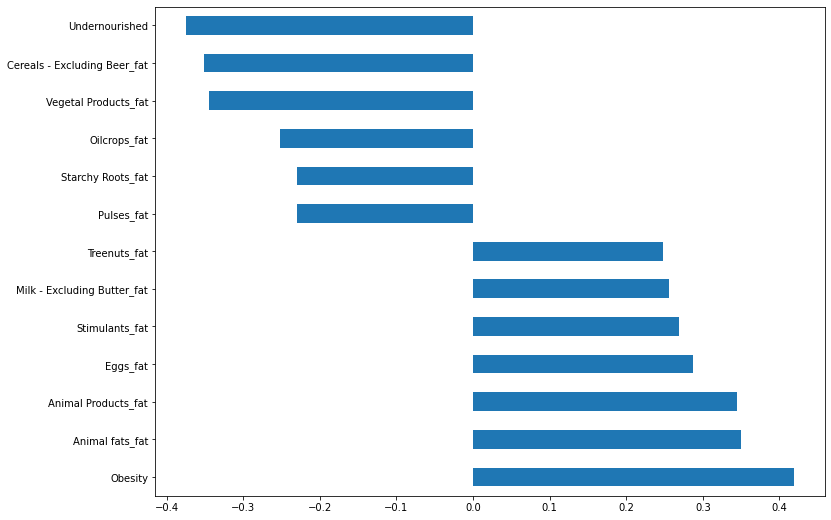

In [58]:
plt.figure(figsize=(12, 9))
golden_features_dict['Confirmed'].plot(kind='barh')

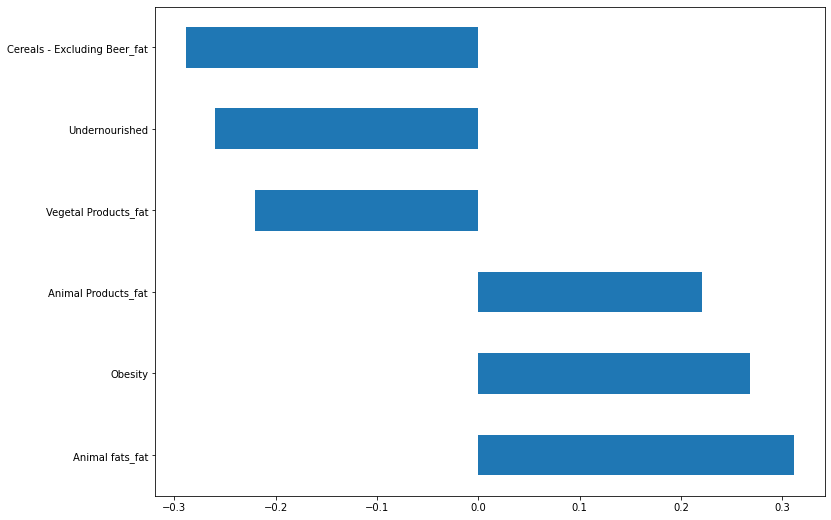

In [59]:
plt.figure(figsize=(12, 9))
golden_features_dict['Deaths'].plot(kind='barh')

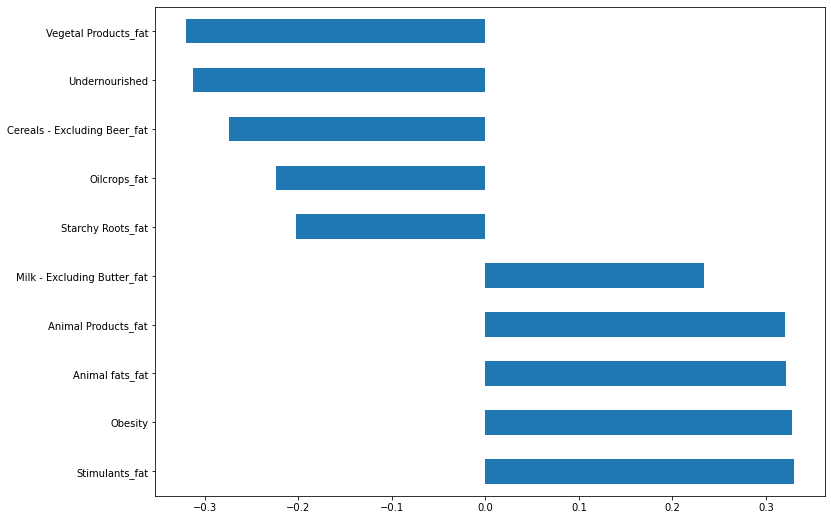

In [60]:
plt.figure(figsize=(12, 9))
golden_features_dict['Recovered'].plot(kind='barh')

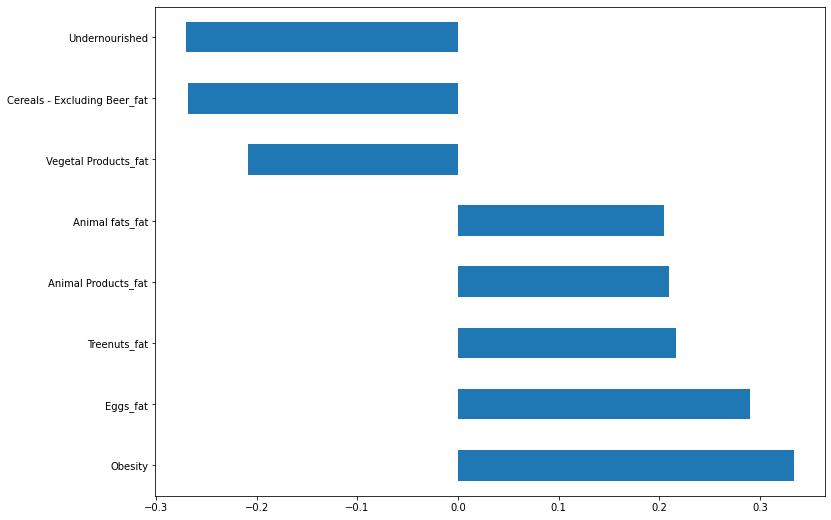

In [61]:
plt.figure(figsize=(12, 9))
golden_features_dict['Active'].plot(kind='barh')

## Remover outliers

In [62]:
colunas_outlier = data_num.columns.to_list()

dataset['is outlier'] = detectar_outliers(dataset, colunas=colunas_outlier, metodo='local outlier fraction', 
                                          contamination=0.000001)
print (str(list(dataset['is outlier']).count(1)) + ' outliers detectados')
dataset = dataset[dataset['is outlier']==0]

1 outliers detectados


## Separando features das targets

In [63]:
y_dict = {}
for t in targets:
    y_dict[t] = dataset[t]

## Feature engineering

In [64]:
cols = dataset.columns.to_list()

In [65]:
features = [f for f in cols if f not in targets]

x_features = dataset[features].copy()

In [66]:
x_features.head()

,Country,Obesity,Undernourished,Population,Unit (all except Population),Alcoholic Beverages_fat,Animal Products_fat,Animal fats_fat,"Aquatic Products, Other_fat",Cereals - Excluding Beer_fat,...,Spices_fat,Starchy Roots_fat,Stimulants_fat,Sugar Crops_fat,Sugar & Sweeteners_fat,Treenuts_fat,Vegetal Products_fat,Vegetable Oils_fat,Vegetables_fat,is outlier
0,Afghanistan,4.5,29.800000,38042000.0,%,0.0,21.6397,6.2224,0.0,8.0353,...,0.2776,0.0490,0.0980,0.0,0.0,0.7513,28.3684,17.0831,0.3593,0
1,Albania,22.3,6.200000,2858000.0,%,0.0,32.0002,3.4172,0.0,2.6734,...,0.0000,0.0510,0.5270,0.0,0.0,0.9181,17.9998,9.2443,0.6503,0
2,Algeria,26.6,3.900000,43406000.0,%,0.0,14.4175,0.8972,0.0,4.2035,...,0.1568,0.1129,0.2886,0.0,0.0,0.8595,35.5857,27.3606,0.5145,0
3,Angola,6.8,25.000000,31427000.0,%,0.0,15.3041,1.3130,0.0,6.5545,...,0.0103,0.7078,0.1128,0.0,0.0,0.0308,34.7010,22.4638,0.1231,0
4,Antigua and Barbuda,19.1,11.258442,97000.0,%,0.0,27.7033,4.6686,0.0,3.2153,...,0.3591,0.0449,1.0549,0.0,0.0,0.2020,22.2995,14.4436,0.2469,0


In [67]:
del x_features['Unit (all except Population)']

In [68]:
del x_features['is outlier']

In [69]:
x_features.dtypes.value_counts()

float64    26
object      1
dtype: int64

In [70]:
x_features_orig = x_features.copy()

In [71]:
data_num = x_features.select_dtypes(include = ['float64', 'int64'])
data_cat = x_features.select_dtypes(include = ['object'])
colunas_a_normalizar = data_num.columns.tolist()
colunas_a_codificar = data_cat.columns.tolist()

<Figure size 432x288 with 0 Axes>

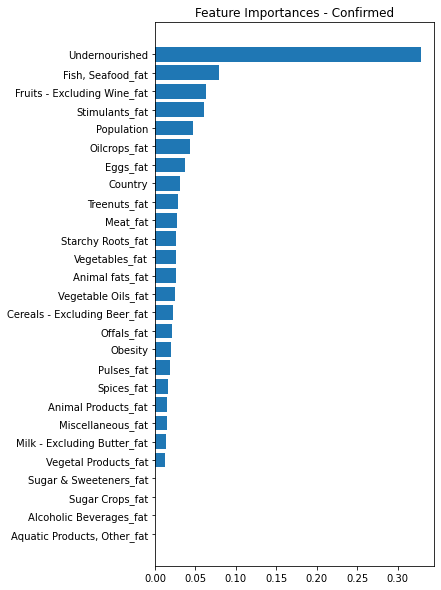

<Figure size 432x288 with 0 Axes>

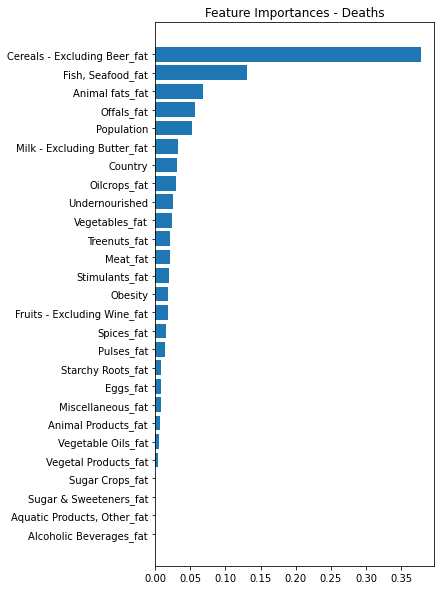

<Figure size 432x288 with 0 Axes>

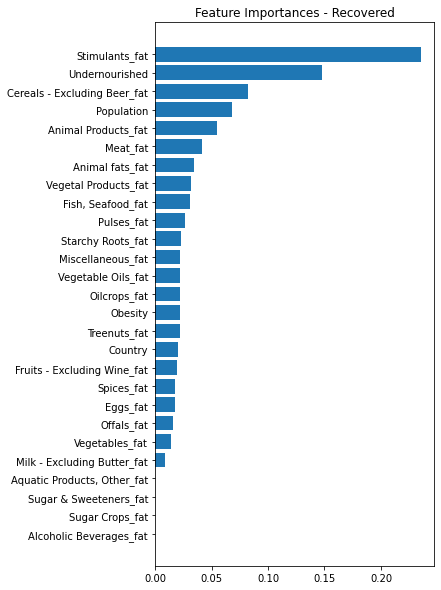

<Figure size 432x288 with 0 Axes>

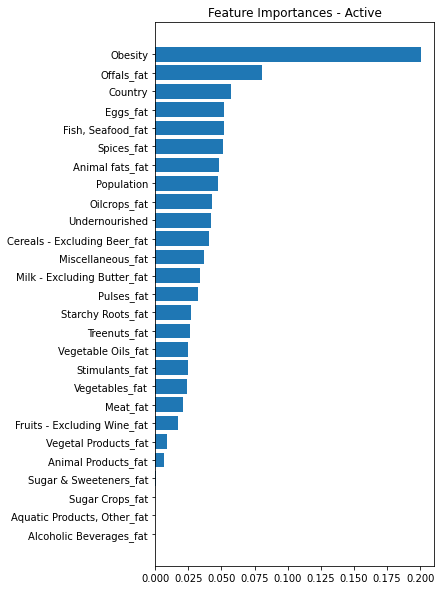

In [72]:
features_importances_dict = {}
features_names_dict = {}
for t in targets:
    features_names_sort, feature_importances_sort = importancia_das_features(x_features, y_dict[t], colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, nome_variavel = t)
    features_importances_dict[t] = feature_importances_sort
    features_names_dict[t] = features_names_sort

<Figure size 432x288 with 0 Axes>

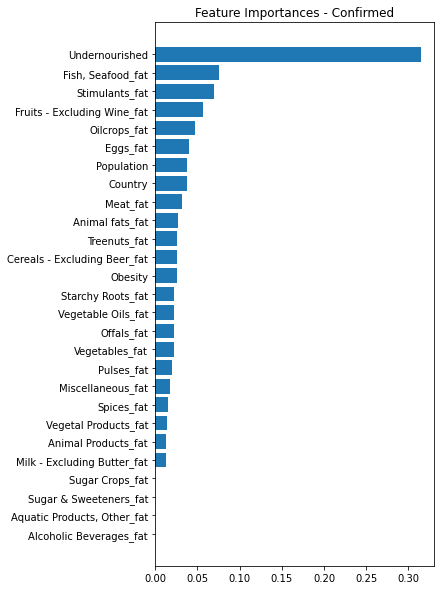

Undernourished 0.31468509364024283
Fish, Seafood_fat 0.07579539515561175
Stimulants_fat 0.06934353396948915
Fruits - Excluding Wine_fat 0.05719560492821355
Oilcrops_fat 0.04712695400730433
Eggs_fat 0.04027924549325024
Population 0.03811313302709667
Country 0.03810659772261523
Meat_fat 0.031756379421853706
Animal fats_fat 0.026643407623664253
Treenuts_fat 0.02598939540002058
Cereals - Excluding Beer_fat 0.02597961907845475
Obesity 0.025487356897886077
Starchy Roots_fat 0.022765360932612323
Vegetable Oils_fat 0.022569916014228364
Offals_fat 0.022471051756765642
Vegetables_fat 0.02236452148613319
Pulses_fat 0.01979619966622188
Miscellaneous_fat 0.017328670468200608
Spices_fat 0.015374454649977753
Vegetal Products_fat 0.01391675194375904
Animal Products_fat 0.013396144009875023
Milk - Excluding Butter_fat 0.013378141140050072
Sugar Crops_fat 9.275653297365186e-05
Sugar & Sweeteners_fat 4.300062967500269e-05
Aquatic Products, Other_fat 1.0615464684598386e-06
Alcoholic Beverages_fat 2.528573

<Figure size 432x288 with 0 Axes>

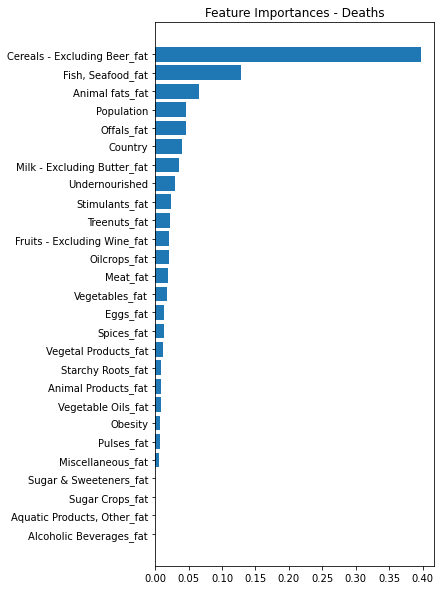

Cereals - Excluding Beer_fat 0.39722104683995724
Fish, Seafood_fat 0.12842931234208715
Animal fats_fat 0.06546928601879744
Population 0.04682514060214152
Offals_fat 0.046010740461833156
Country 0.039856189189426766
Milk - Excluding Butter_fat 0.03623206320763819
Undernourished 0.029956811646253457
Stimulants_fat 0.023500972452721636
Treenuts_fat 0.021808146846436213
Fruits - Excluding Wine_fat 0.021148848285569857
Oilcrops_fat 0.020263351380756422
Meat_fat 0.01882585033363755
Vegetables_fat 0.018264361783500053
Eggs_fat 0.013840499348302395
Spices_fat 0.013333479364901295
Vegetal Products_fat 0.011270343358025134
Starchy Roots_fat 0.009552691816173782
Animal Products_fat 0.009149277186071052
Vegetable Oils_fat 0.009084674594245029
Obesity 0.007572745955055316
Pulses_fat 0.00665801382971845
Miscellaneous_fat 0.00553337202758453
Sugar & Sweeteners_fat 0.00010128560730298998
Sugar Crops_fat 9.14955218634737e-05
Aquatic Products, Other_fat 0.0
Alcoholic Beverages_fat 0.0


<Figure size 432x288 with 0 Axes>

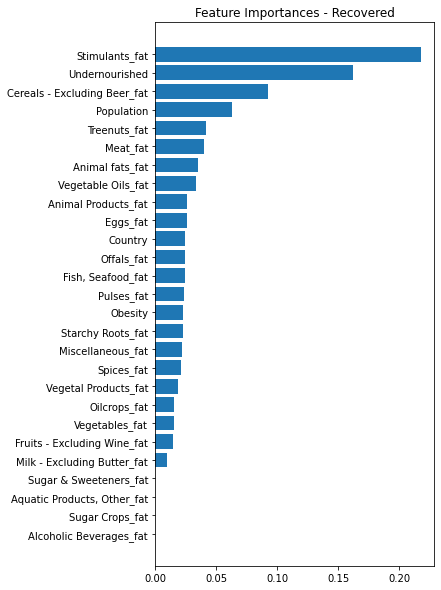

Stimulants_fat 0.21786986663392702
Undernourished 0.1623929441069994
Cereals - Excluding Beer_fat 0.0927117103026065
Population 0.06273698968543165
Treenuts_fat 0.04176449228837047
Meat_fat 0.040360732325421415
Animal fats_fat 0.03556986366724112
Vegetable Oils_fat 0.03348560681582237
Animal Products_fat 0.025999061469903183
Eggs_fat 0.025977319659071154
Country 0.024764377948852834
Offals_fat 0.0247572001349729
Fish, Seafood_fat 0.02413517686090143
Pulses_fat 0.02351596255202702
Obesity 0.023178378567722972
Starchy Roots_fat 0.02265481706688857
Miscellaneous_fat 0.022252226336472423
Spices_fat 0.020878120631937034
Vegetal Products_fat 0.01907102358706338
Oilcrops_fat 0.015764628154469416
Vegetables_fat 0.01555646949324851
Fruits - Excluding Wine_fat 0.015096677236519711
Milk - Excluding Butter_fat 0.00944219463772271
Sugar & Sweeteners_fat 3.3734123067912184e-05
Aquatic Products, Other_fat 2.3585866346703068e-05
Sugar Crops_fat 6.5545706253204965e-06
Alcoholic Beverages_fat 2.85276366

<Figure size 432x288 with 0 Axes>

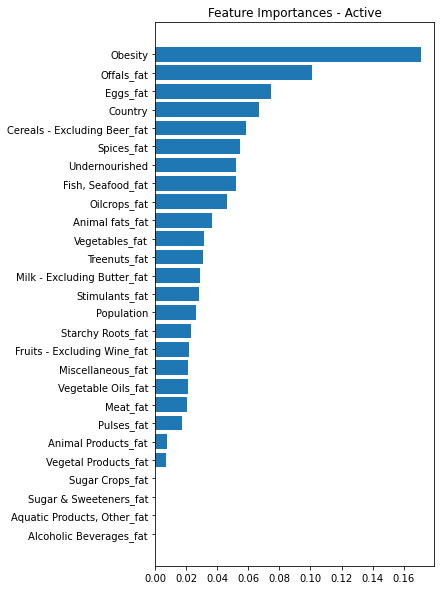

Obesity 0.1709626967196873
Offals_fat 0.10101405591556141
Eggs_fat 0.07435216719323096
Country 0.06696323995404116
Cereals - Excluding Beer_fat 0.0582307811305563
Spices_fat 0.054593340984310436
Undernourished 0.05236439008897857
Fish, Seafood_fat 0.05178316739147377
Oilcrops_fat 0.046464008678379375
Animal fats_fat 0.03662134035205894
Vegetables_fat 0.0314244660759526
Treenuts_fat 0.031065852765600022
Milk - Excluding Butter_fat 0.02900544142409955
Stimulants_fat 0.02833093761701876
Population 0.026203119700542135
Starchy Roots_fat 0.0231439936260014
Fruits - Excluding Wine_fat 0.02203302921007942
Miscellaneous_fat 0.021468473718303197
Vegetable Oils_fat 0.020950063767688144
Meat_fat 0.020587115136293254
Pulses_fat 0.017442844311014852
Animal Products_fat 0.007941313938150259
Vegetal Products_fat 0.006731792607565348
Sugar Crops_fat 0.00017437664575565995
Sugar & Sweeteners_fat 0.00011809012794577457
Aquatic Products, Other_fat 2.370410860330044e-05
Alcoholic Beverages_fat 6.196811108

In [73]:
x_features_slct = {}
features_slct = {}
for t in targets:
    x_features_slct[t], features_slct[t] = selecionar_features(x_features, y_dict[t], y_name=t, colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, limite_corr=0.9, limite_importancia=0.99, quantidade=99)


In [74]:
for t in targets:
    print (t + " " +str(len(features_slct[t])))

Confirmed 22
Deaths 22
Recovered 22
Active 22


<Figure size 432x288 with 0 Axes>

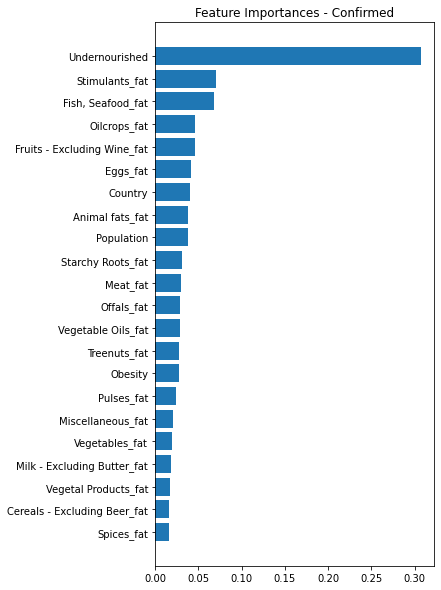

<Figure size 432x288 with 0 Axes>

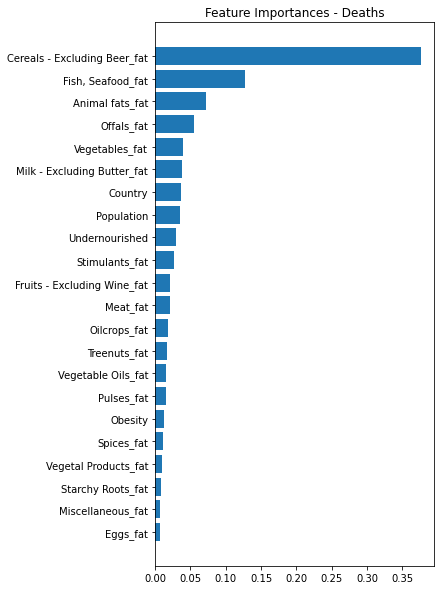

<Figure size 432x288 with 0 Axes>

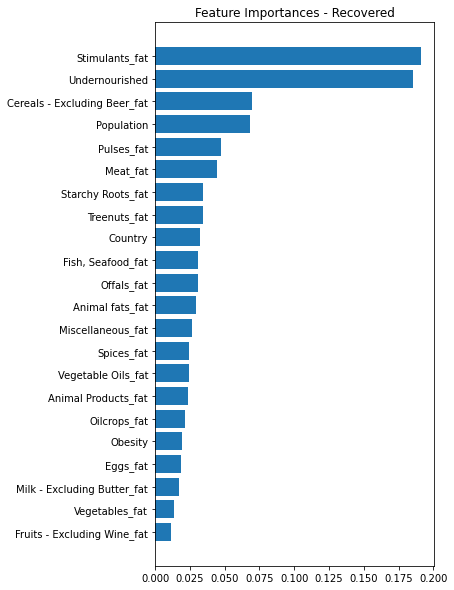

<Figure size 432x288 with 0 Axes>

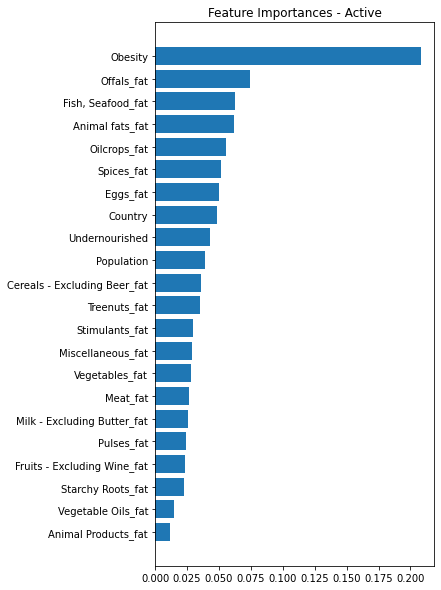

In [75]:
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_num_slct = data_num.columns.tolist()
    colunas_categ_slct = data_cat.columns.tolist()
    
    x_features_importance_pratica = x_features_slct[t][features_slct[t]]
    
    features_names_sort_slct, feature_importances_sort_slct = importancia_das_features(x_features_importance_pratica, y_dict[t], colunas_numericas=colunas_num_slct, colunas_categoricas = colunas_categ_slct, nome_variavel = t)


## Separando dado de treino e teste

In [76]:
x_train_dict = {}
y_train_dict = {}
x_test_dict = {}
y_test_dict = {}

x_train_dict_sens = {}
y_train_dict_sens = {}
x_test_dict_sens = {}
y_test_dict_sens = {}

for t in targets:
    x_train_dict[t], x_test_dict[t], y_train_dict[t], y_test_dict[t] = train_test_split(x_features_slct[t], y_dict[t], test_size=0.01, random_state=42)
    x_train_dict_sens[t], x_test_dict_sens[t], y_train_dict_sens[t], y_test_dict_sens[t] = train_test_split(x_features_slct[t], y_dict[t], test_size=0.5, random_state=42)
    print (y_train_dict[t].shape, y_test_dict[t].shape)

(158,) (2,)
(158,) (2,)
(158,) (2,)
(158,) (2,)


## Pré processamento

In [77]:
colunas_a_normalizar = {}
colunas_a_codificar = {}
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_a_normalizar[t] = data_num.columns.tolist()
    colunas_a_codificar[t] = data_cat.columns.tolist()

scaler_dict = {}
for t in targets:
    _, scaler = normalizar_numericas(x_train_dict[t], colunas_a_normalizar[t])
    _, scaler_sens = normalizar_numericas(x_train_dict_sens[t], colunas_a_normalizar[t])
    scaler_dict[t] = scaler
    x_test_dict[t][colunas_a_normalizar[t]] = scaler_dict[t].transform(x_test_dict[t][colunas_a_normalizar[t]])
    x_test_dict_sens[t][colunas_a_normalizar[t]] = scaler_sens.transform(x_test_dict_sens[t][colunas_a_normalizar[t]])

encoder_dict = {}
for t in targets:
    if colunas_a_codificar[t] == []: continue
    x_train_dict[t], enc = codificar_categoricas(x_train_dict[t], colunas_categoricas = colunas_a_codificar[t])
    x_train_dict_sens[t], enc_sens = codificar_categoricas(x_train_dict_sens[t], colunas_categoricas = colunas_a_codificar[t])
    encoder_dict[t] = enc
    test_categ = pd.DataFrame(enc.transform(x_test_dict[t][colunas_a_codificar[t]]).toarray())
    x_test_dict[t].reset_index(inplace=True, drop=True)
    x_test_dict[t] = pd.concat([test_categ, x_test_dict[t][colunas_a_normalizar[t]]], axis=1)
    
    test_categ_sens = pd.DataFrame(enc_sens.transform(x_test_dict_sens[t][colunas_a_codificar[t]]).toarray())
    x_test_dict_sens[t].reset_index(inplace=True, drop=True)
    x_test_dict_sens[t] = pd.concat([test_categ_sens, x_test_dict_sens[t][colunas_a_normalizar[t]]], axis=1)

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


## Análise de sensibilidade

In [78]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
msle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score, greater_is_better=True)

metricas = {'mse': mse_scorer,
            'mae': mae_scorer
           }

errors = [mean_squared_error, mean_absolute_error]

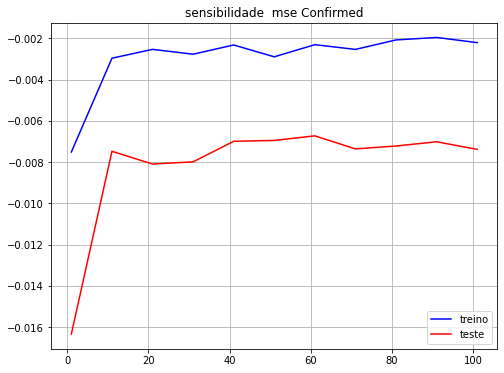

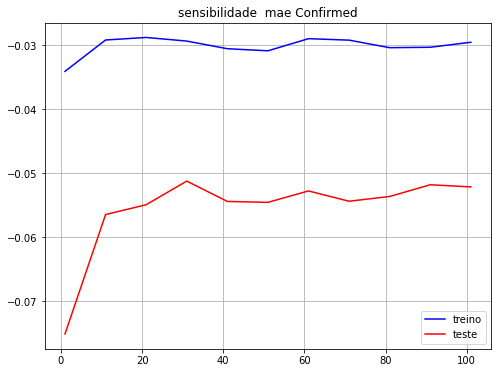

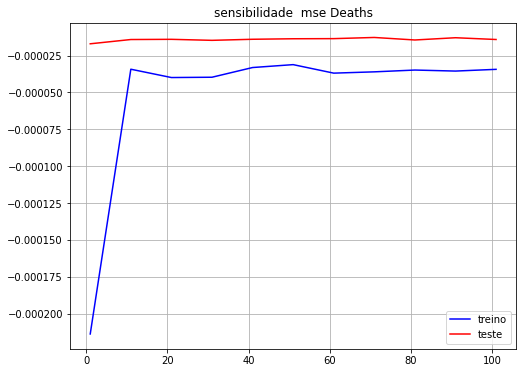

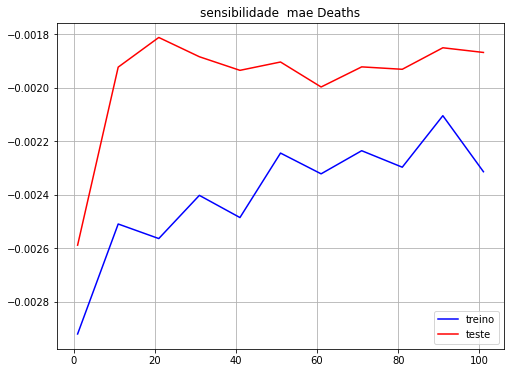

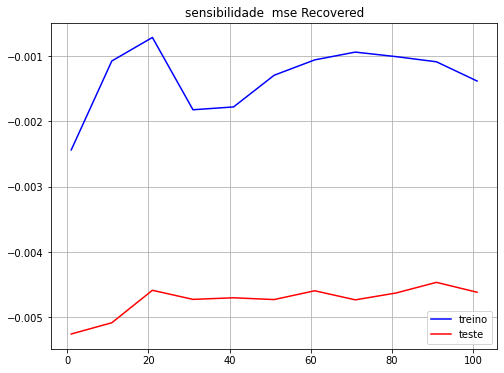

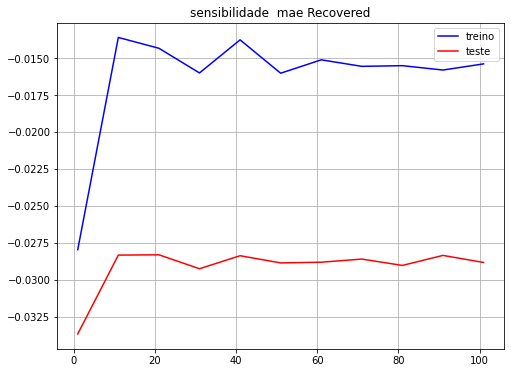

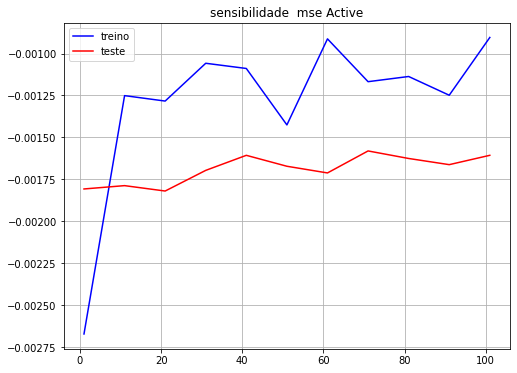

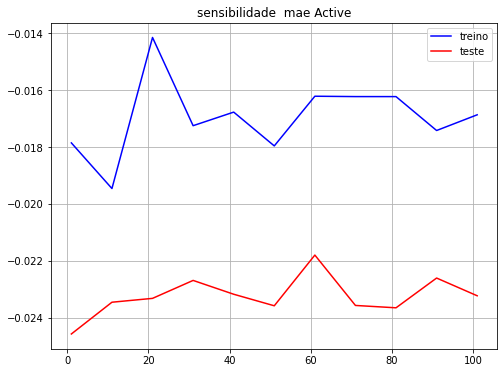

In [79]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = BaggingRegressor(base_estimator=ExtraTreeRegressor(), 
                                     n_estimators=n_arvores,
                                     n_jobs = -1)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

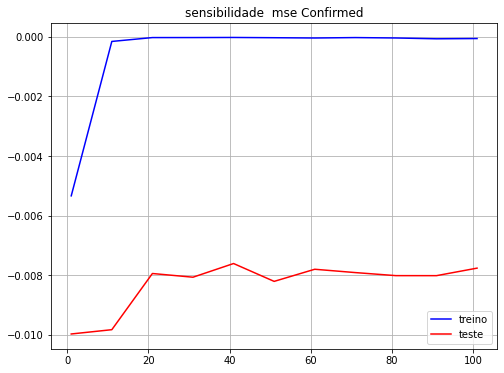

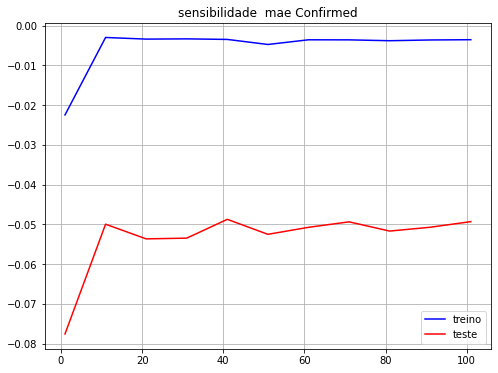

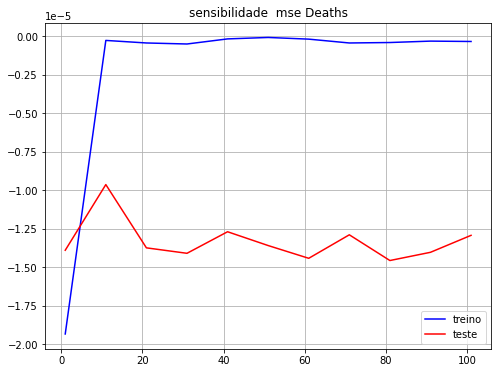

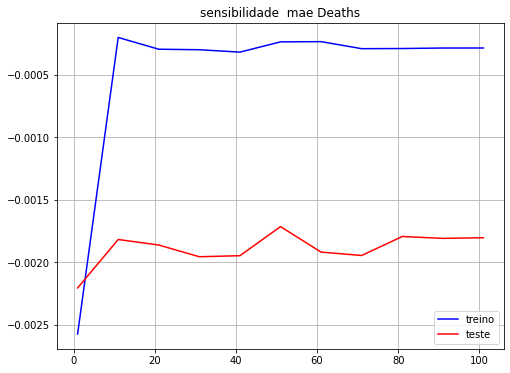

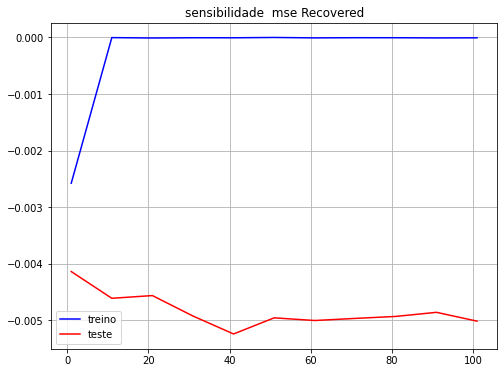

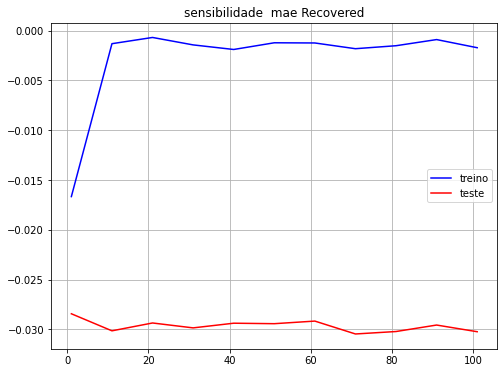

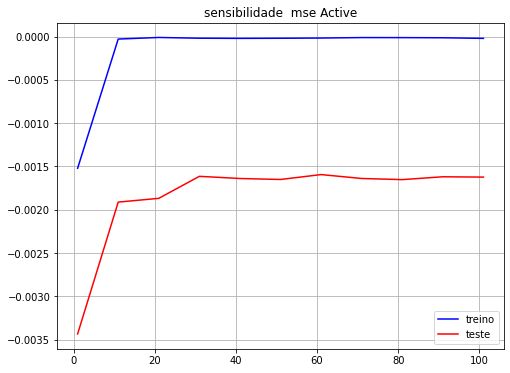

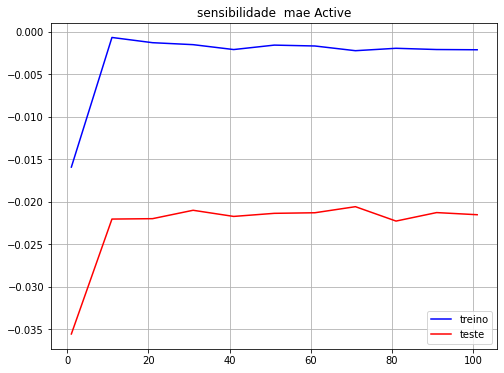

In [80]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = AdaBoostRegressor(base_estimator=ExtraTreeRegressor(), 
                                      n_estimators=n_arvores)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

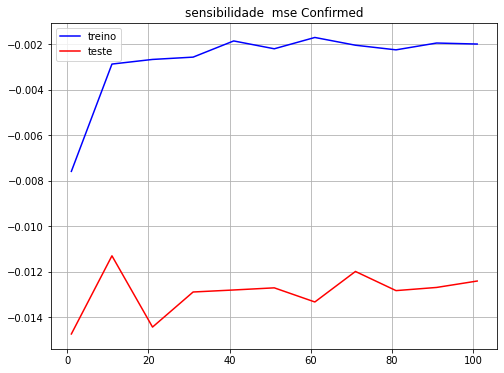

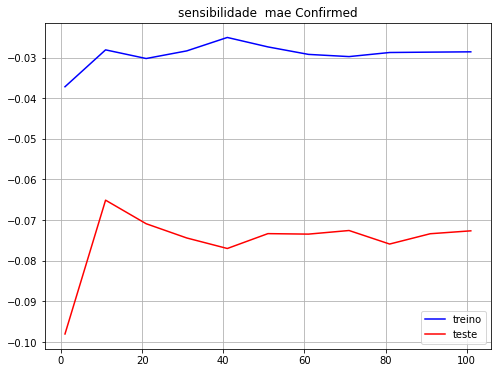

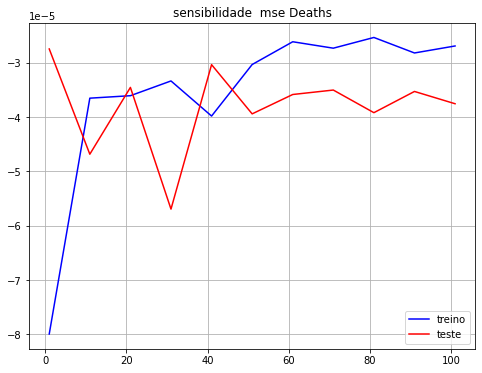

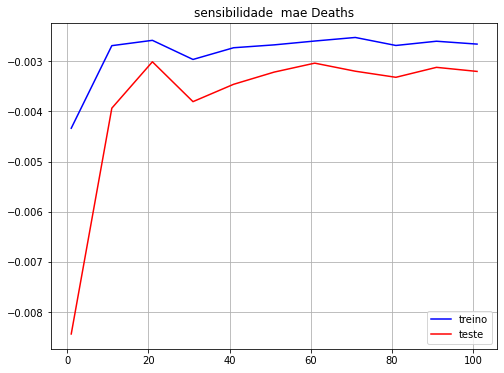

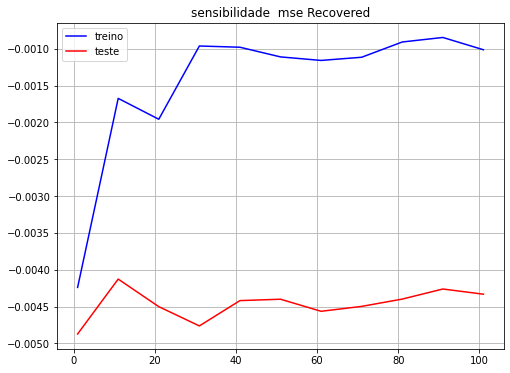

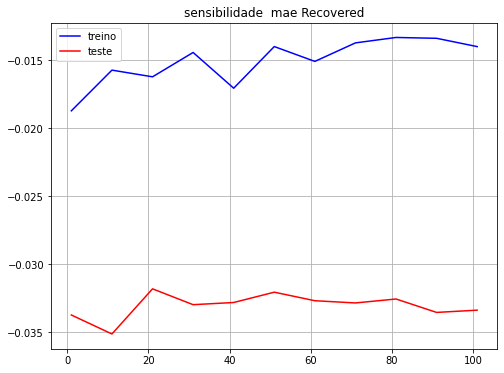

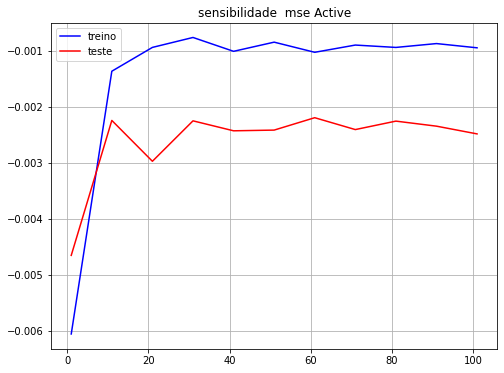

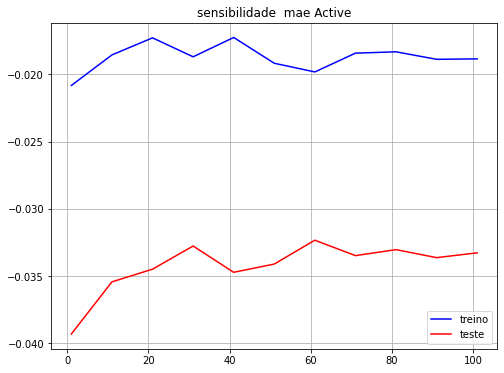

In [81]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = RandomForestRegressor(n_estimators=n_arvores,
                                     n_jobs = -1)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

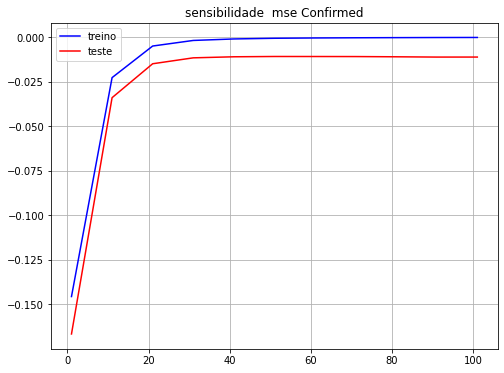

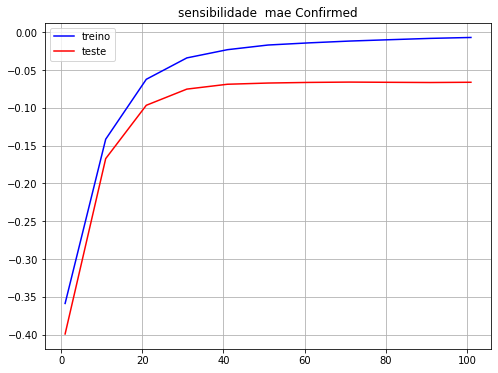

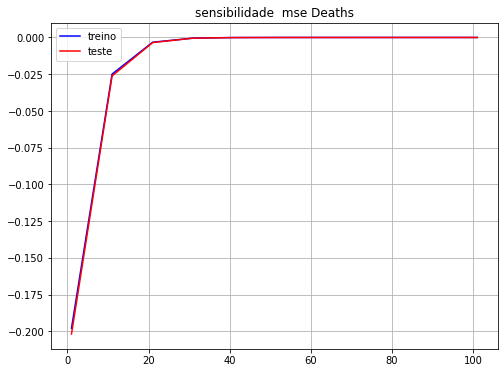

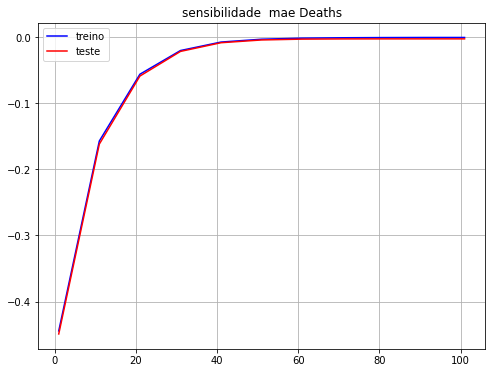

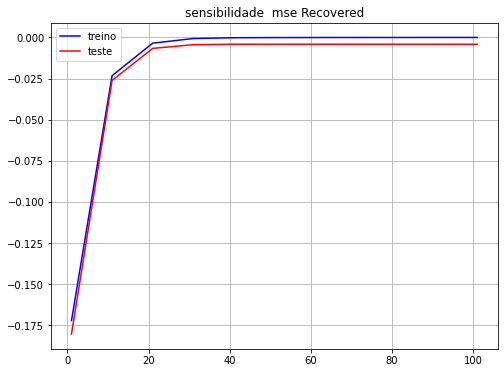

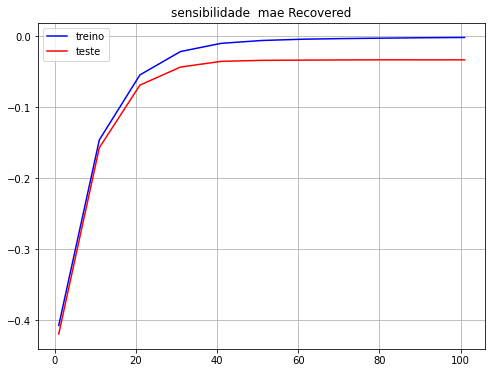

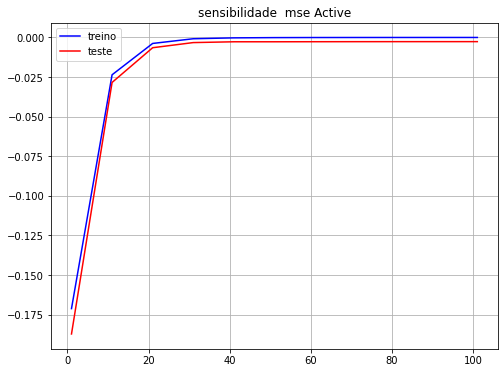

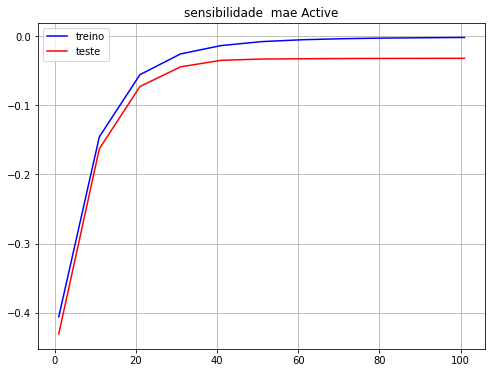

In [82]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = xgb.XGBRegressor(n_estimators=n_arvores,
                                     n_jobs = -1, objective='reg:squarederror')

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

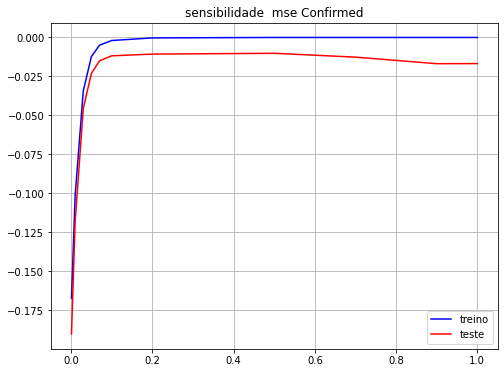

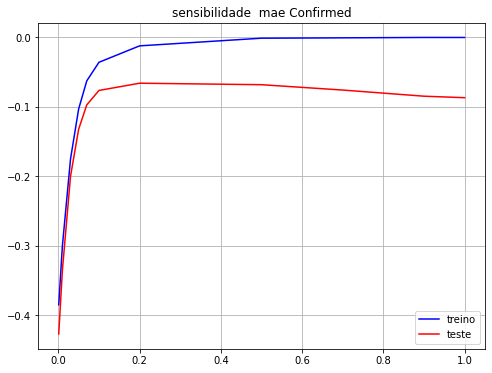

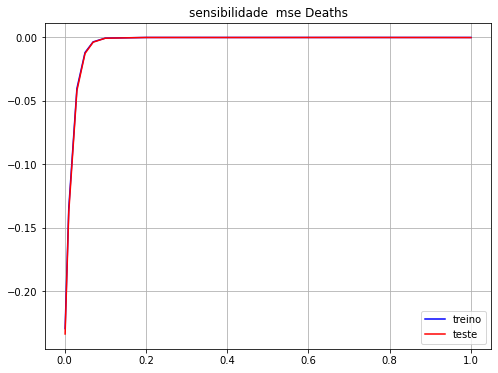

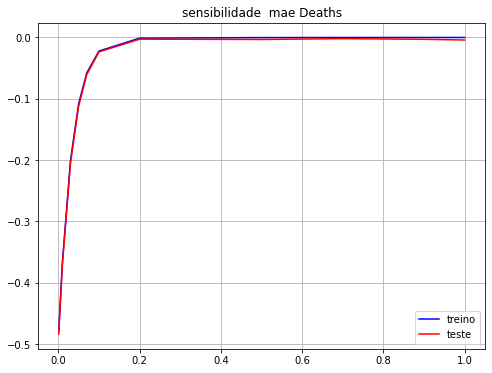

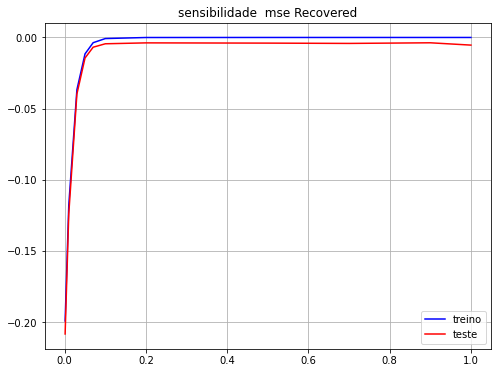

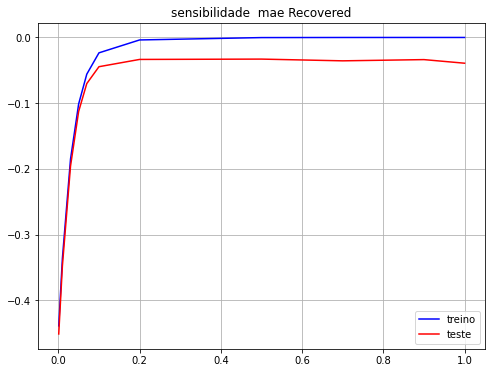

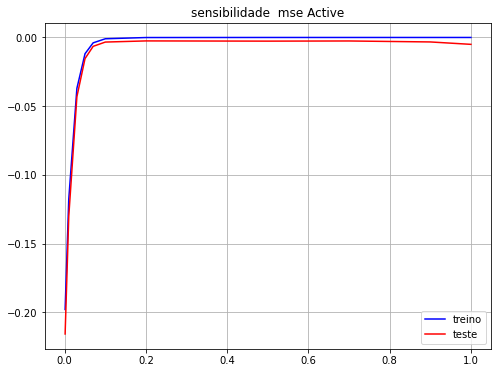

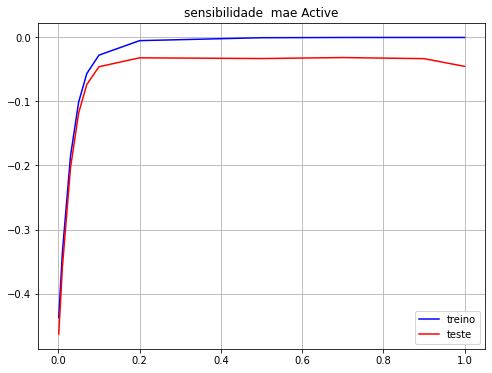

In [97]:
lista_learning_rate = [0.001, 0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 0.7, 0.9, 1.]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for lr in lista_learning_rate:
            model = xgb.XGBRegressor(n_estimators=30,
                                     learning_rate=lr,
                                     n_jobs = -1, objective='reg:squarederror')

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_learning_rate, train_results, 'b', label="treino")
        plt.plot(lista_learning_rate, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

## Model selection: otimização

In [83]:
modelos_dict = {'ridge': Ridge(),
                'lasso': Lasso(),
                'bagging': BaggingRegressor(),
                'adaboost': AdaBoostRegressor(),
                'random forest': RandomForestRegressor(),
                'gradient boosting':xgb.XGBRegressor(),
                }

ridge_param_grid = {'alpha': stats.uniform(loc=0.001, scale=1000),
                    'max_iter': np.arange(1000, 10000, 1000),
                    }

lasso_param_grid = {'alpha': stats.uniform(loc=0.001, scale=1000),
                    'max_iter': np.arange(1000, 10000, 1000),
                    }

bagging_param_grid = {'base_estimator': [DecisionTreeRegressor(), ExtraTreeRegressor(), Ridge(), Lasso()], 
                      'n_estimators': [10, 20, 30, 40, 50], 
                      'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                      'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                      'bootstrap': [True], 
                      'bootstrap_features': [False, True],
                      'n_jobs': [-1]
                     }

adaboost_param_grid = {'base_estimator': [DecisionTreeRegressor(), ExtraTreeRegressor(), Ridge(), Lasso()],
                       'n_estimators': [10, 20, 30, 40, 50], 
                       'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
                       'loss': ['linear', 'square', 'exponential']
                      }

rf_param_grid = {'n_estimators': [10, 20, 30, 40, 50],
                 'max_features': np.arange(1, 20, 1),
                 'max_depth':np.arange(1, 20, 1),
                 'min_samples_split': np.arange(2, 20, 1),
                 "bootstrap": [True, False],
                 'n_jobs': [-1]
                 }

gdbt_param_grid = {'max_depth': np.arange(3, 20, 1),
                   'learning_rate': stats.uniform(loc=0.1, scale=0.3),
                   'n_estimators': [10, 20, 30, 40, 50],
                   'n_jobs': [-1],
                   'gamma': stats.uniform(loc=0.001, scale=10),
                   'subsample': stats.uniform(loc=0.1, scale=0.9),
                   'colsample_bytree': stats.uniform(loc=0.1, scale=0.9),
                   'reg_alpha': stats.uniform(loc=0.001, scale=10),
                   'reg_lambda': stats.uniform(loc=0.01, scale=5),
                   'booster': ['gbtree', 'gblinear', 'dart'],
                   'objective': ['reg:squarederror']
                   }


param_dict = {'ridge':ridge_param_grid,
              'lasso': lasso_param_grid,
              'bagging': bagging_param_grid,
              'adaboost': adaboost_param_grid,
              'random forest': rf_param_grid,
              'gradient boosting':gdbt_param_grid,
             }

In [84]:
n_iteracoes = 10

In [85]:
%%time

resultados_dict = {}
otm_time_dict = {}
melhor_modelo_dict = {}
melhor_modelo_nome = {}
melhores_parametros_dict = {}
best_score = {}
resultados = {}

n_folds = 10

loo = LeaveOneOut()

for t in targets:
    _, _, _, resultados[t], _ = busca_aleatoria(x_train_dict[t], y_train_dict[t], Ridge(), param_dict['ridge'], metricas, n_folds=loo.split(x_train_dict[t]), n_iter=n_iteracoes)
    resultados[t]['nome'] = 'ridge'

for t in targets:
    best_score[t] = -9999.
    melhor_modelo_nome[t] = None
    melhor_modelo_dict[t] = None
    melhores_parametros_dict[t] = None
    for nome, modelo in modelos_dict.items():
        print (nome)
        melhor_modelo, melhores_parametros, score, result, otm_time = busca_aleatoria(x_train_dict[t], y_train_dict[t], modelo, param_dict[nome], metricas, n_folds=loo.split(x_train_dict[t]), n_iter=n_iteracoes)
        result['nome'] = nome
        resultados[t] = pd.concat([resultados[t], result])
        if score > best_score[t]:
            melhor_modelo_nome[t] = nome
            melhor_modelo_dict[t] = melhor_modelo
            melhores_parametros_dict[t] = melhores_parametros
            best_score[t] = score



 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
ridge

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
lasso

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
bagging

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
adaboost

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
random forest

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
gradient boosting

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
ridge

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
lasso

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
bagging

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
adaboost

 
 buscando melhores parâ

In [86]:
for t in targets:
    print (resultados[t].shape)
    resultados[t].sort_values(by='mean_test_'+list(metricas.keys())[0], inplace=True, ascending=False)

(70, 348)
(70, 348)
(70, 348)
(70, 348)


In [87]:
for t in targets:
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        print (met_nome, t, resultados[t]['mean_test_'+list(metricas.keys())[i]].max())

mse Confirmed -0.011503832546457737
mae Confirmed -0.06043096386171543
mse Deaths -0.00010443662636774996
mae Deaths -0.004113313781063898
mse Recovered -0.005803036116377726
mae Recovered -0.03576808880048511
mse Active -0.003736461786966064
mae Active -0.03257087819793478


In [88]:
for t in targets:
    print (t, best_score[t])

Confirmed -0.011503832546457737
Deaths -0.00010443662636774996
Recovered -0.005803036116377726
Active -0.003736461786966064


In [89]:
resultados['Confirmed'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
3,-0.011504,0.028945,1,-0.071484,0.079962,3,random forest
6,-0.011539,0.029993,2,-0.070839,0.080754,1,random forest
8,-0.011589,0.029733,3,-0.071453,0.080520,2,random forest
5,-0.011946,0.030440,4,-0.073741,0.080673,5,random forest
2,-0.011966,0.030837,5,-0.074681,0.079929,6,random forest
4,-0.012038,0.031753,6,-0.073377,0.081572,4,random forest
1,-0.012054,0.030949,7,-0.076098,0.079136,7,random forest
7,-0.012055,0.033157,1,-0.068849,0.085529,2,bagging
8,-0.012067,0.031239,1,-0.062604,0.090267,2,adaboost
4,-0.012115,0.036266,2,-0.060431,0.091993,1,adaboost


In [90]:
resultados['Deaths'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
5,-0.000104,0.000498,1,-0.004636,0.009107,2,random forest
9,-0.000107,0.000491,2,-0.004760,0.009194,3,random forest
2,-0.000107,0.000505,3,-0.004869,0.009149,5,random forest
4,-0.000108,0.000509,4,-0.004566,0.009343,1,random forest
8,-0.000108,0.000501,5,-0.004911,0.009168,6,random forest
1,-0.000108,0.000515,6,-0.004776,0.009249,4,random forest
1,-0.000110,0.000489,1,-0.004915,0.009262,2,bagging
7,-0.000110,0.000457,2,-0.004982,0.009233,3,bagging
3,-0.000111,0.000488,3,-0.004988,0.009269,4,bagging
6,-0.000111,0.000502,7,-0.005013,0.009269,8,random forest


In [91]:
resultados['Recovered'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
5,-0.005803,0.027855,1,-0.040918,0.064255,4,random forest
6,-0.005843,0.027092,2,-0.040882,0.064587,3,random forest
3,-0.005978,0.027944,3,-0.040306,0.065977,2,random forest
3,-0.005979,0.027206,1,-0.039642,0.066392,5,bagging
5,-0.006121,0.028162,2,-0.037480,0.068673,2,bagging
6,-0.006163,0.029914,3,-0.038815,0.068235,3,bagging
1,-0.006173,0.028167,4,-0.043256,0.065587,6,random forest
7,-0.006269,0.029308,5,-0.040181,0.068227,1,random forest
3,-0.006386,0.029110,1,-0.044745,0.066215,1,ridge
2,-0.006388,0.028811,2,-0.045117,0.065970,4,ridge


In [92]:
resultados['Active'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
9,-0.003736,0.010083,1,-0.039395,0.046739,2,random forest
3,-0.003806,0.010196,2,-0.039794,0.047138,5,random forest
7,-0.003806,0.009599,3,-0.039099,0.047725,1,random forest
4,-0.003825,0.010297,4,-0.039741,0.047385,4,random forest
1,-0.003847,0.010433,5,-0.039501,0.047814,3,random forest
6,-0.003920,0.010766,6,-0.040780,0.047505,8,random forest
0,-0.003944,0.011203,1,-0.038767,0.049411,3,bagging
8,-0.003960,0.011602,7,-0.040785,0.047918,9,random forest
0,-0.003980,0.011066,8,-0.040570,0.048315,7,random forest
2,-0.004012,0.011583,9,-0.040494,0.048702,6,random forest


## Testar modelo

In [93]:
for t in targets:
    modelo = melhor_modelo_dict[t]
    if modelo == None: continue
    modelo.fit(x_train_dict[t], y_train_dict[t])

tabela_compara_dict = {}
train_scores = {}
test_scores = {}
biases = {}
variances = {}

for t in targets:
    modelo = melhor_modelo_dict[t]
    
    tabela_compara_dict[t+' treino'] = []
    tabela_compara_dict[t+' treino baseline'] = []
    
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        if modelo == None: continue
        
        train_scores[t] = metrica(modelo, x_train_dict[t], y_train_dict[t]) 
        test_scores[t] = metrica(modelo, x_test_dict[t], y_test_dict[t])
        
        baseline_train = errors[i](y_train_dict[t], np.ones((y_train_dict[t].shape)) * y_train_dict[t].mean())
        baseline_test = errors[i](y_test_dict[t], np.ones((y_test_dict[t].shape)) * y_train_dict[t].mean())
        
        print ( met_nome + ": score de treino " + str(-metrica(modelo, x_train_dict[t], y_train_dict[t]).round(4)) + " e score de teste: " + str(-metrica(modelo, x_test_dict[t], y_test_dict[t]).round(4)) + " para target: " + str(t))
        print ( met_nome + ": baseline treino " + str(baseline_train.round(4)) + " baseline teste: " + str(baseline_test.round(4)) + " para target: " + str(t))
        
        tabela_compara_dict[t+' treino baseline'].append(baseline_train)
        tabela_compara_dict[t+' treino'].append(-metrica(modelo, x_train_dict[t], y_train_dict[t]))
        

mse: score de treino 0.0056 e score de teste: 0.0036 para target: Confirmed
mse: baseline treino 0.0164 baseline teste: 0.0033 para target: Confirmed
mae: score de treino 0.0494 e score de teste: 0.0554 para target: Confirmed
mae: baseline treino 0.0956 baseline teste: 0.0428 para target: Confirmed
mse: score de treino 0.0 e score de teste: 0.0 para target: Deaths
mse: baseline treino 0.0001 baseline teste: 0.0 para target: Deaths
mae: score de treino 0.0022 e score de teste: 0.0021 para target: Deaths
mae: baseline treino 0.006 baseline teste: 0.0025 para target: Deaths
mse: score de treino 0.0025 e score de teste: 0.0009 para target: Recovered
mse: baseline treino 0.0073 baseline teste: 0.0011 para target: Recovered
mae: score de treino 0.0278 e score de teste: 0.0294 para target: Recovered
mae: baseline treino 0.0512 baseline teste: 0.0314 para target: Recovered
mse: score de treino 0.0007 e score de teste: 0.0003 para target: Active
mse: baseline treino 0.0046 baseline teste: 0.000

In [94]:
for t in targets:
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        print (met_nome, 'leave one out treino', t, resultados[t]['mean_test_'+list(metricas.keys())[i]].min())

mse leave one out treino Confirmed -0.06640516439302672
mae leave one out treino Confirmed -0.2435924930238459
mse leave one out treino Deaths -0.16681627790668324
mae leave one out treino Deaths -0.408264059016721
mse leave one out treino Recovered -0.08720400165340399
mae leave one out treino Recovered -0.2893207517154426
mse leave one out treino Active -0.010838382698291413
mae leave one out treino Active -0.09889167618652375


In [95]:
tabela_compara = pd.DataFrame.from_dict(tabela_compara_dict, orient='index', columns=['MSE', 'MAE'])

In [96]:
tabela_compara

,MSE,MAE
Confirmed treino,0.005633,0.049360
Confirmed treino baseline,0.016403,0.095625
Deaths treino,0.000021,0.002231
Deaths treino baseline,0.000134,0.006047
Recovered treino,0.002538,0.027799
Recovered treino baseline,0.007324,0.051161
Active treino,0.000723,0.018811
Active treino baseline,0.004572,0.045398
